Gliezel Ann Pajarilla
CMSC 197 - Machine Learning

In [2]:
##### Standard Libraries #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
##### For preprocessing #####
import os
import re
import email
import codecs
##### For performance evaluation #####
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score

## (A) Importing pre-processed data

Data were preprocessed by removing numbers, punctuations, stop words etc and exported into a csv file

In [3]:
#### improrting pre-processed data
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

preprocessed_path = '/content/drive/My Drive/FOURTH YEAR/Subjects/CMSC 197/trec06/preprocessed_data/preprocessed_emails.csv'

Mounted at /content/drive


In [4]:
#### loading the data in a dataframe
data = pd.read_csv(preprocessed_path)
data.head()

,folder,file,message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1


## (B) Splitting to train and test set

Folders less than or equal to 70 were assigned to train and 70 above are assigned to test. The train_df was further split into either 0 = 'ham' and 1 = 'spam'.

In [5]:
#### splitting the train and the test set
train_df = data[data['folder'] <= 70]
test_df = data[data['folder'] > 70]

train_ham_df = train_df[train_df['classification'] == 0]
train_spam_df = train_df[train_df['classification'] == 1]

In [6]:
#### checking the test size of the train and test
print('Train dataset size:', len(train_df))
print('Test dataset size:', len(test_df))
print('Train ham dataset size:', len(train_ham_df))
print('Train spam dataset size:', len(train_spam_df))


Train dataset size: 19910
Test dataset size: 15389
Train ham dataset size: 7450
Train spam dataset size: 12460


In [7]:
data

,folder,file,message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
35294,126,16,bla bla bla eee rererreerer er,1
35295,126,18,oil sector going crazy weekly gift kkpt thing ...,1
35296,126,19,suffering pain depression heartburn well help ...,1
35297,126,20,prosperous future increased money earning powe...,1


In [8]:
#### cleaned with nan (empty) in the message
data = data.dropna()
data


,folder,file,message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
3,0,3,greetings verify subscription planfans list ch...,0
4,0,4,chauncey conferred luscious continued tonsillitis,1
...,...,...,...,...
35294,126,16,bla bla bla eee rererreerer er,1
35295,126,18,oil sector going crazy weekly gift kkpt thing ...,1
35296,126,19,suffering pain depression heartburn well help ...,1
35297,126,20,prosperous future increased money earning powe...,1


In [9]:
#### checking test df
train_spam_df

,folder,file,message,classification
1,0,1,luxury watches buy rolex rolex cartier bvlgari...,1
2,0,2,academic qualifications prestigious nonacc red...,1
4,0,4,chauncey conferred luscious continued tonsillitis,1
7,0,7,nbc today  body diet beaches magazines hollyw...,1
8,0,8,oil sector going crazy weekly gift kkpt thing ...,1
...,...,...,...,...
19904,70,294,txtadd,1
19905,70,295,スピード！簡単！無料！ 今どきの出会いの仕方ですね。 問 xinwallacom,1
19906,70,296,special offer adobe video collection adobe pre...,1
19907,70,297,doctype html public wcdtd html transitionalen ...,1


In [10]:
#### checking train df
train_ham_df

,folder,file,message,classification
0,0,0,mailing list queried weeks ago running set arc...,0
3,0,3,greetings verify subscription planfans list ch...,0
5,0,5,quiet quiet well straw poll plan running,0
6,0,6,working departed totally bell labs recommended...,0
10,0,10,greetings mass acknowledgement signed planfans...,0
...,...,...,...,...
19883,70,270,equation generate prime numbers equation theor...,0
19884,70,271,equation generate prime numbers equation theor...,0
19899,70,288,dear dmdx users guidance generating dmdx item ...,0
19903,70,293,built handyboard works great testmotor passes ...,0


Traversing through each file to count the occurences in order to obtain the top 10,000 most frequent words

# Getting 10 000 words

In [35]:
from collections import Counter
#### Count top 10,000 words from the training dataset
word_counts = Counter(word for message in train_df['message'] for word in str(message).split())
top_10000_words = dict(word_counts.most_common(10000))

## Creating a list of top 10,000 words
top_10000_words_list = list(top_10000_words.keys())

Returns in the dictionary the word and its key based on its frequency arranged in descending order.

In [37]:
#### displays word and its occurence

for word, count in word_counts.most_common(10):
  print(f"{word}: {count}")


will: 10440
board: 4904
price: 4549
company: 4224
adobe: 3902
nil: 3762
time: 3716
email: 3597
list: 3447
dont: 3201


# (C) Feature Matrix Ham & Spam Messages


(a) spam with 10 000 columns that matches the 10 000 words where 0 and 1 refers to the presence or absence of the word

In [ ]:
#### Initialize feature matrix for spam
feature_matrix_spam = np.zeros((len(train_spam_df), 10000))

for i, message in enumerate(train_spam_df['message'].fillna('')):
    for word in set(message.split()):
        if word in top_10000_words_list:
            feature_matrix_spam[i][top_10000_words_list.index(word)] = 1

In [15]:
#### initialzied feature matrix for spam
print(feature_matrix_spam)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(b) ham with 10 000 columns that matches the 10 000 words where 0 and 1 refers to the presence or absence of the word

In [17]:
#### Initialize feature matrix for ham
feature_matrix_ham = np.zeros((len(train_ham_df), 10000))

for i, message in enumerate(train_ham_df['message'].fillna('')):
    for word in set(message.split()):
        if word in top_10000_words_list:
            feature_matrix_ham[i][top_10000_words_list.index(word)] = 1

In [18]:
#### initialzied feature matrix for ham
print(feature_matrix_ham)


[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Sparse matrix representation of the word displayed in its position


In [19]:
## sparse matrix
messages_split = train_df['message'].apply(lambda x: str(x).split())
max_words = max(messages_split.apply(len))
max_columns = 127

df_words = pd.DataFrame(np.full((len(messages_split), max_columns), None))
for i, words in enumerate(messages_split):
    for j, word in enumerate(words[:max_columns]):
        df_words.iloc[i, j] = word

df_words.head()


,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,mailing,list,queried,weeks,ago,running,set,archive,server,official,...,doesnt,moment,unix,software,endeavors,guys,copyrighted,planning,setting,quotation
1,luxury,watches,buy,rolex,rolex,cartier,bvlgari,frank,muller,patek,...,None,None,None,None,None,None,None,None,None,None
2,academic,qualifications,prestigious,nonacc,redited,uni,versities,knowledge,experience,lack,...,None,None,None,None,None,None,None,None,None,None
3,greetings,verify,subscription,planfans,list,charter,members,signed,day,order,...,None,None,None,None,None,None,None,None,None,None
4,chauncey,conferred,luscious,continued,tonsillitis,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [14]:
test_df

,folder,file,message,classification
19910,71,0,hesitantly derive perverse satisfaction clodho...,1
19911,71,1,things perform experiment display will remain ...,0
19912,71,2,best offer month viggra ci ialis vaiium xa naa...,1
19913,71,3,de ar wne cr doesnt matter ow real st mmed ia ...,1
19914,71,4,special offer adobe video collection adobe pre...,1
...,...,...,...,...
35294,126,16,bla bla bla eee rererreerer er,1
35295,126,18,oil sector going crazy weekly gift kkpt thing ...,1
35296,126,19,suffering pain depression heartburn well help ...,1
35297,126,20,prosperous future increased money earning powe...,1


# (D) Computing the Priors

Where (1) train_spam_df is the number of spam emails in the training set,
(2) train_ham_df is the number of ham emails in the training set,(3) train_df is the total number of emails (contains both ham and spam messages)

In [20]:
#### Calculate prior probabilities for spam and ham

prior_spam = len(train_spam_df) / len(train_df)
prior_ham = 1 - prior_spam

print(f"Prior probability of spam: {prior_spam}")
print(f"Prior probability of ham: {prior_ham}")


Prior probability of spam: 0.6258161727774988
Prior probability of ham: 0.3741838272225012


# (E) Computing the Likelihood of each word

### applying to spam and ham classification with Laplace smoothing

In [56]:
#### function for laplace smoothing
def laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes):
    prob_word_given_spam = np.zeros(len(top_10000_words))
    prob_word_given_ham = np.zeros(len(top_10000_words))

    spam_word_count = np.sum(feature_matrix_spam, axis=0)
    ham_word_count = np.sum(feature_matrix_ham, axis=0)

    total_spam_words = np.sum(spam_word_count)
    total_ham_words = np.sum(ham_word_count)


    for i in range(len(top_10000_words)):
        prob_word_given_spam[i] = (spam_word_count[i] + laplace_smoothing_val) / (total_spam_words + laplace_smoothing_val * num_classes)
        prob_word_given_ham[i] = (ham_word_count[i] + laplace_smoothing_val) / (total_ham_words + laplace_smoothing_val * num_classes)

    return prob_word_given_spam, prob_word_given_ham

## initializing laplace smoothing parameter and number of classes
laplace_smoothing_val = 1
num_classes = 2
spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes)



In [ ]:
#### print likelihood of being spam or ham
print(f"Likelihood of a word being in a spam email: {spam_word_probs}")
print(f"Likelihood of a word being in a ham email: {ham_word_probs}")


Likelihood of a word being in a spam email: [5.24104624e-03 5.39628174e-04 3.41025294e-03 ... 2.71046115e-05
 2.46405559e-06 2.46405559e-06]
Likelihood of a word being in a ham email: [6.56481019e-03 5.79756964e-03 3.69198464e-04 ... 2.30749040e-05
 5.76872601e-05 4.03810820e-05]


In [ ]:
## table form of the likelihood

likelihood_df = pd.DataFrame({
    'Word': top_10000_words_list,
    'P(Word|Spam)': spam_word_probs,
    'P(Word|Ham)': ham_word_probs
})

likelihood_df.head(20)


,Word,P(Word|Spam),P(Word|Ham)
0,will,0.005241,0.006565
1,board,0.000540,0.005798
2,price,0.003410,0.000369
3,company,0.003073,0.000436
4,adobe,0.001286,0.000017
5,nil,0.000002,0.000069
6,time,0.002306,0.003784
7,email,0.001252,0.004067
8,list,0.000310,0.002861
9,dont,0.002341,0.004214


# Classifying the emails

In [57]:
#### classifying the emails using the computed probabilities
def classify_email(email, spam_word_probs, ham_word_probs, prob_spam, prob_ham):
    log_prob_spam = 0
    log_prob_ham = 0

    words = str(email).split()

    for word in words:
        if word in top_10000_words:
            log_prob_spam += np.log(spam_word_probs[top_10000_words_list.index(word)])
            log_prob_ham += np.log(ham_word_probs[top_10000_words_list.index(word)])

    log_prob_spam += np.log(prob_spam)
    log_prob_ham += np.log(prob_ham)

    return 1 if log_prob_spam > log_prob_ham else 0

In [59]:
## tabular form the df in classifying email [actual and predicted]
test_df['predicted_classification'] = test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))

classification_results_df = pd.DataFrame({
    'Message': test_df['message'],
    'Actual Classification': test_df['classification'],
    'Predicted Classification': test_df['predicted_classification']
})

classification_results_df.head(20)


<ipython-input-59-65cad345ddda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_classification'] = test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))


,Message,Actual Classification,Predicted Classification
19910,hesitantly derive perverse satisfaction clodho...,1,1
19911,things perform experiment display will remain ...,0,0
19912,best offer month viggra ci ialis vaiium xa naa...,1,1
19913,de ar wne cr doesnt matter ow real st mmed ia ...,1,1
19914,special offer adobe video collection adobe pre...,1,1
19915,multipart message mime format dragon contentty...,1,1
19916,txtadd,1,1
19917,mistersporty incorporation rambrantplein ad de...,1,0
19918,choice best choice drugs viagra pill viagra so...,1,1
19919,ive changed dmdx listserv subject filter hopef...,0,0


# Testing the classifier

# Test Set

In [61]:
#### classify the test emails
test_df.loc[:,'predicted'] = test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))
correct_test = (test_df['classification'] == test_df['predicted']).sum()
incorrect_test = len(test_df) - correct_test

print(f'Correctly classified emails ({correct_test / len(test_df) * 100}%)')
print(f'Incorrectly classified emails ({incorrect_test / len(test_df) * 100}%)')

Correctly classified emails (78.38715965949704%)
Incorrectly classified emails (21.612840340502956%)


<ipython-input-61-3e913108acd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'predicted'] = test_df['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))


In [ ]:
#### correct_test in a dataframe
correct_df = test_df[test_df['classification'] == test_df['predicted']]
print("DataFrame of Correctly Classified Emails")
display(correct_df)


DataFrame of Correctly Classified Emails


,folder,file,message,classification,predicted_classification,predicted
19910,71.0,0.0,hesitantly derive perverse satisfaction clodho...,1.0,1.0,1
19911,71.0,1.0,things perform experiment display will remain ...,0.0,0.0,0
19912,71.0,2.0,best offer month viggra ci ialis vaiium xa naa...,1.0,1.0,1
19913,71.0,3.0,de ar wne cr doesnt matter ow real st mmed ia ...,1.0,1.0,1
19914,71.0,4.0,special offer adobe video collection adobe pre...,1.0,1.0,1
...,...,...,...,...,...,...
35294,126.0,16.0,bla bla bla eee rererreerer er,1.0,1.0,1
35295,126.0,18.0,oil sector going crazy weekly gift kkpt thing ...,1.0,1.0,1
35296,126.0,19.0,suffering pain depression heartburn well help ...,1.0,1.0,1
35297,126.0,20.0,prosperous future increased money earning powe...,1.0,1.0,1


# Performance evaluation

In [ ]:
print(test_df['classification'].isnull().sum())
test_df = test_df.dropna(subset=['classification'])

1


Text(50.722222222222214, 0.5, 'Actual')

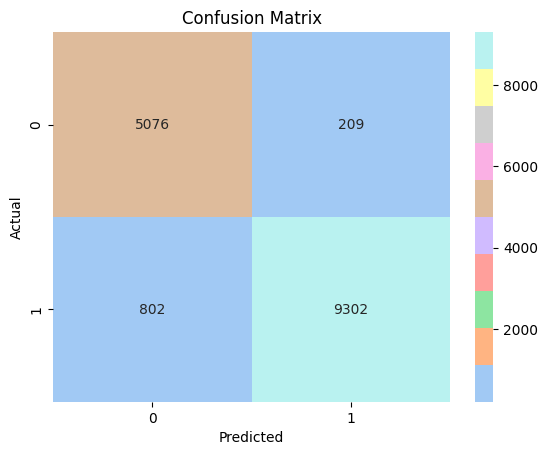

In [ ]:
#### creating array of the actual and predicted classifications
actual = test_df['classification'].to_numpy()
predicted = test_df['predicted'].to_numpy()

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual, predicted)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=sns.color_palette("pastel"))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
#### calculating accuracy, precision, recall
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")


Accuracy = 0.93430372343882
Precision = 0.9780254442224793
Recall = 0.9206254948535234


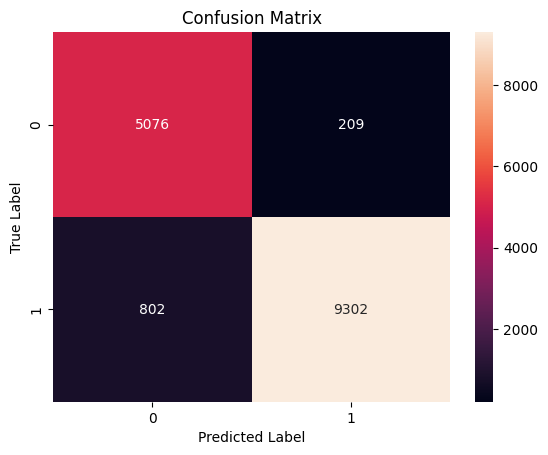

True Negative Rate (TN) - 5076
False Positive Rate (FP) - 209
False Negative Rate (FN) - 802
True Positive Rate (TP) - 9302


In [ ]:
#### false positives, false negative, true positive, true negative
actual = np.array(test_df['classification'])
predicted = np.array(test_df['predicted'])
confusion_matrix = metrics.confusion_matrix(actual, predicted, labels = [0, 1])
sns.heatmap(confusion_matrix, annot = True, fmt = 'd')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("True Negative Rate (TN) - {}".format(confusion_matrix[0][0]))
print("False Positive Rate (FP) - {}".format(confusion_matrix[0][1]))
print("False Negative Rate (FN) - {}".format(confusion_matrix[1][0]))
print("True Positive Rate (TP) - {}".format(confusion_matrix[1][1]))


True positive rate was the highest, followed by true negative rates and then false negative rate and false positive rate. High TPR indicates that the model prioritizes classifying spam messages eventhough some ham emails may be misclassified.

# (Q1). What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

### The csv obtained was from the original without using functions for cleaning such as removing the stop words. After, done the same method with the processes of obtaining accuracy, precision, and recall

In [ ]:
#### utilized stop and those did not use the stop words
#Accuracy = 0.8947300019494444
#Precision = 0.9734375
#Recall = 0.8632224861441014

accuray_non_stopwords = 0.8947300019494444
recall_non_stopwords = 0.9734375
precision_non_stopwords = 0.8632224861441014

accuracy_stopwords = 0.93430372343882
recall_stopwords = 0.9780254442224793
precision_stopwords = 0.9206254948535234


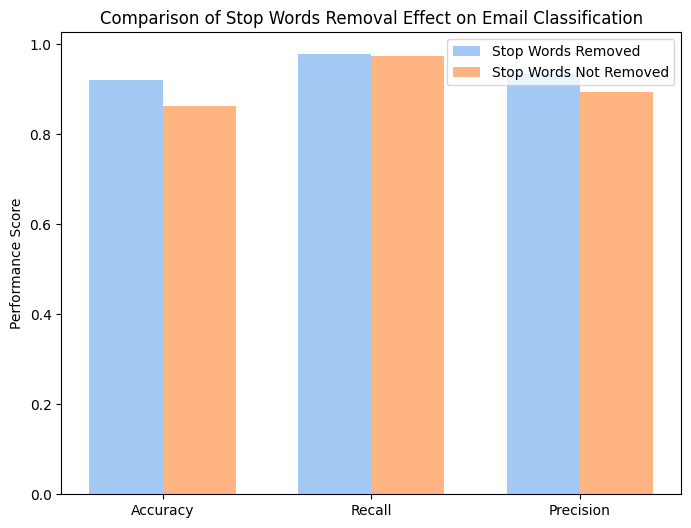

In [ ]:
#### visualizing precision, recall and accuracy
precision_removed_stopwords = 0.93430372343882
recall_removed_stopwords = 0.9780254442224793
accuracy_removed_stopwords = 0.9206254948535234

precision_notremoved_stopwords = 0.8947300019494444
recall_notremoved_stopwords = 0.9734375
accuracy_notremoved_stopwords = 0.8632224861441014

stop_words_performance = {
    'Accuracy': accuracy_removed_stopwords,
    'Recall': recall_removed_stopwords,
    'Precision': precision_removed_stopwords
}

non_stop_words_performance = {
    'Accuracy': accuracy_notremoved_stopwords,
    'Recall': recall_notremoved_stopwords,
    'Precision': precision_notremoved_stopwords
}

metrics = ['Accuracy', 'Recall', 'Precision']
stop_words_values = [stop_words_performance[metric] for metric in metrics]
non_stop_words_values = [non_stop_words_performance[metric] for metric in metrics]

x = range(len(metrics))

plt.figure(figsize=(8, 6))

## plotting
plt.bar(x, stop_words_values, width=0.35, align='center', label='Stop Words Removed', color= sns.color_palette("pastel")[0])
plt.bar([i + 0.35 for i in x], non_stop_words_values, width=0.35, align='center', label='Stop Words Not Removed', color=sns.color_palette("pastel")[1])

plt.xticks([i + 0.35 / 2 for i in x], metrics)
plt.ylabel('Performance Score')
plt.title('Comparison of Stop Words Removal Effect on Email Classification')
plt.legend()
plt.show()


Accuracy, recall and precision was highest when the stop words were removed than it was not removed. When stop words were not removed, there are possible noises in the data and would populate the feature matrix with the words like a, able, about which may not always carry significant meaning. Thus, removing it makes it much better for the model to focus more informative words that may contribute for it being a spam or ham

# Q2. Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k= 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

In [ ]:
#### experimenting and filtering for k = 50
k = 50
sorted_dict = dict(top_10000_words)
sorted_dict

filtered_dict_50 = {x: y for x, y in sorted_dict.items() if y > k}
filtered_dict_50_list = list(filtered_dict_50.keys())
print(f"Filtered Dictionary (k=50): {len(filtered_dict_50)}")

Filtered Dictionary (k=50): 4614


In [ ]:
#### experimenting and filtering for k = 100
k = 100
sorted_dict = dict(top_10000_words)
sorted_dict

filtered_dict_100 = {x: y for x, y in sorted_dict.items() if y > k}
filtered_dict_100_list = list(filtered_dict_100.keys())
print(f"Filtered Dictionary (k=100): {len(filtered_dict_100)}")

Filtered Dictionary (k=100): 2580


As the k values (minimum frequency threshold) was increased, it would result to having fewer words that appeared more frequently. In order to determine the specific threshold to improve the performance, one must experiment in the k value to filter out most frequent words that appeared n times.

# Q3. Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

In [ ]:
#### using the different lambda values
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

test_df_l0p1 = test_df.copy()
if 'predicted' in test_df_l0p1.columns:
  test_df_l0p1 = test_df_l0p1.drop('predicted', axis=1)

results = []

## iterate through different lambda values
for laplace_smoothing_val in lambda_values:
  spam_word_probs, ham_word_probs = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, laplace_smoothing_val, num_classes)
  test_df_l0p1['predicted'] = test_df_l0p1['message'].apply(lambda x: classify_email(x, spam_word_probs, ham_word_probs, prior_spam, prior_ham))

  ## calculating metrics
  actual = test_df_l0p1['classification'].to_numpy()
  predicted = test_df_l0p1['predicted'].to_numpy()

  accuracy = accuracy_score(actual, predicted)
  precision = precision_score(actual, predicted)
  recall = recall_score(actual, predicted)


  results.append({'lambda': laplace_smoothing_val, 'accuracy': accuracy, 'precision': precision, 'recall': recall})


results_df = pd.DataFrame(results)
results_df



,lambda,accuracy,precision,recall
0,2.000,0.932679,0.977464,0.918646
1,1.000,0.934304,0.978025,0.920625
2,0.500,0.934499,0.978435,0.920527
3,0.100,0.933979,0.978517,0.919636
4,0.005,0.933979,0.979022,0.919141


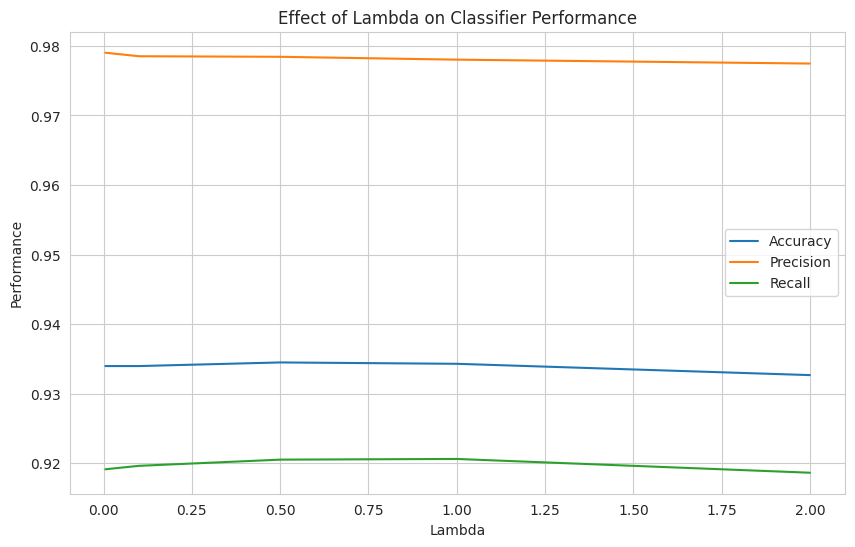

In [ ]:
#### plotting the relationship between lambda and performance metrics
plt.figure(figsize=(10, 6))
plt.plot(results_df['lambda'], results_df['accuracy'], label='Accuracy')
plt.plot(results_df['lambda'], results_df['precision'], label='Precision')
plt.plot(results_df['lambda'], results_df['recall'], label='Recall')
plt.xlabel('Lambda')
plt.ylabel('Performance')
plt.title('Effect of Lambda on Classifier Performance')
plt.legend()
plt.show()


With these, the precision was the highest followed by accuracy and lastly recall. Thus, the model was able to determine a certain email or message as spam which means that there are few false positives or the ones that incorrectly classifies ham emails as spam.

# Visualizations

Visualizing the features

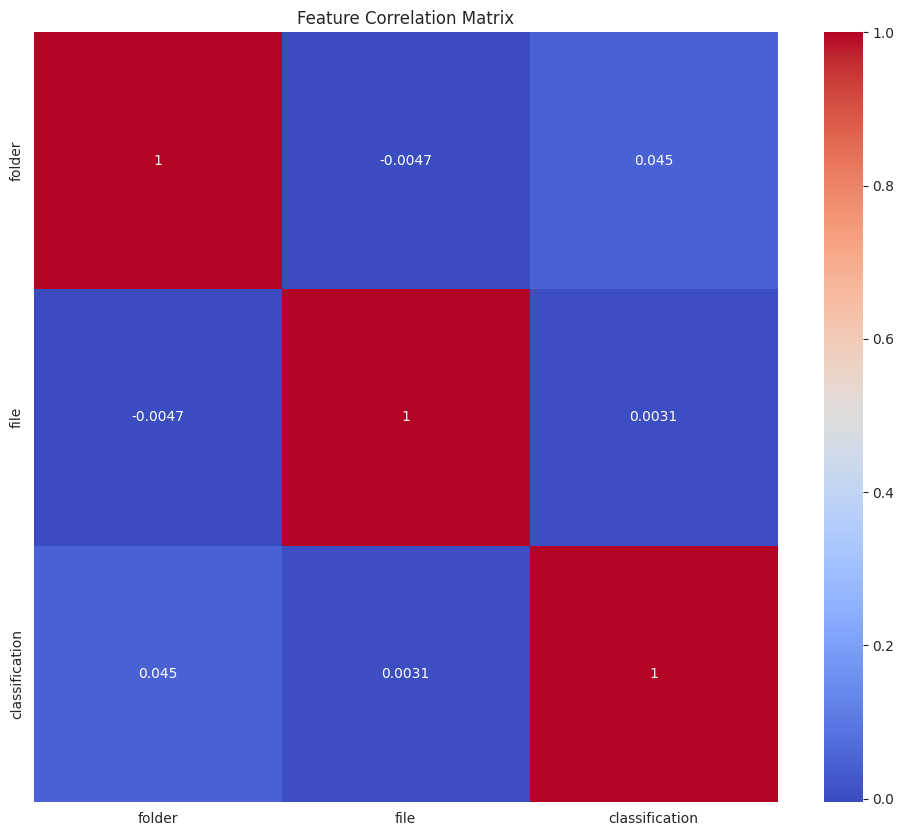

                  folder      file  classification
folder          1.000000 -0.004683        0.044978
file           -0.004683  1.000000        0.003106
classification  0.044978  0.003106        1.000000


In [ ]:
data_numeric = data.select_dtypes(include=[np.number])
data_numeric = data_numeric.dropna()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
pd.set_option("display.max_rows", None, "display.max_columns", None)  # Display all rows and columns
print(correlation_matrix.to_string())  # Print as a formatted string

Features are not highly correlated which supports the Naive Bayes Assumption that it treat features independently of each other. And it is not the main focus in terms of classifying spam and ham.

Where (1) train_spam_df is the number of spam emails in the training set, (2) train_ham_df is the number of ham emails in the training set,(3) train_df is the total number of emails (contains both ham and spam messages)

# Q4. Recommendations to further improve the model

In order to further improve the importance, these are the things that are to be done based on conducting the activity:


1.   Preprocessing should be done correctly since if words were not processed properly, it can influence the training and testing of the model and which can also contribute to noise.
2.   Fo futher improve the model, it would be best to experiment on the k values and the lambda values
3.   Identify features that are highly correlated since the assumption in the Naive Bayes is that they are independent so, it can be visualized through heatmap and clustermap.
4.   Under pre-processing is stemming in which if you have words like cooking, it will be read as cook in which it will reduce the number of the unique words and may improve the model performance by joining related words.
5.   There is also an imbalannce on the training and testing data sizes. One recommendation is to use the stratify parameter of the scikit-learn in order to maintain the class distribution to minimize the risk of being biased to a specific majority class.





